# 🧙 Create an evol-instruct dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/argilla-io/distilabel/blob/main/docs/tutorials/create-evol-instruct-dataset.ipynb) [![Open Source in Github](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/argilla-io/distilabel/blob/main/docs/tutorials/create-evol-instruct-dataset.ipynb)

In this tutorial, we'll develop an evol-instruct dataset by employing the approaches outlined in ["WizardLM: Empowering Large Language Models to Follow Complex Instructions"](https://arxiv.org/pdf/2304.12244.pdf) and [What makes good data for alignment? A comprehensive study of automatic data selection in instruction tuning](https://arxiv.org/pdf/2312.15685.pdf) using `distilabel`. In the next section, we will describe the process in detail. So, let's get started! 🪄

## Introduction

The WizardLM paper proposes a new method, **Evol-Instruct**, to synthetically create a dataset with open-domain instructions of varying complexity using *gpt-3.5-turbo*. The resulting dataset, combined with the original, was used to fine-tune LLaMa, leading to the creation of WizardLM. This model surpasses ChatGPT in both human and automatic evaluations, demonstrating more than 90% of ChatGPT's capabilities in 17 out of 29 skills.

In this tutorial, we will only focus on the *Evol-Instruct* approach to create a more complex dataset. From an *initial dataset* that will be the seed for the evolution process, the steps for each epoch (determined as M=4) are as follows:

1. **Intruction Evolving**: Use *gpt-3.5-turbo* with predefined prompts to generate the evolved instructions. These prompts can be of two types: *in-depth evolving* (includes adding constraints, deepening, concretizing, increasing reasoning, and complicating the input) and *in-breadth evolving* (includes mutation). The complicating prompt is the only one not applied as it needs in-context examples. Then, only one of the remaining five is selected randomly to be applied to the input instruction. You can check the original code [here](https://github.com/nlpxucan/WizardLM/tree/main/Evol_Instruct).
2. **Elimination Evolving**
   * The instruction evolving step may fail, so the new instructions are filtered according to the following criteria:
     1. The evolved instruction *does not provide any information* gain. Automatically evaluated with ChatGPT.
     2. The evolved instruction contains *"sorry" and is less than 80 words*.
     3. The evolved instruction only contains *punctuation and stop words*.
     4. The evolved instruction *copies words* from the evolving prompt.
   * If the evolved instruction passes the previous criteria, it is added to the pool of new instructions and also will be used as input for the next iteration. If not, it is dropped and the original instruction is the one used for the next iteration.

Once, the evolved instructions are generated, they use the same LLM to **generate the corresponding responses**.

Finally, the resulting dataset is the combination of the original and the new instructions generated in each epoch.

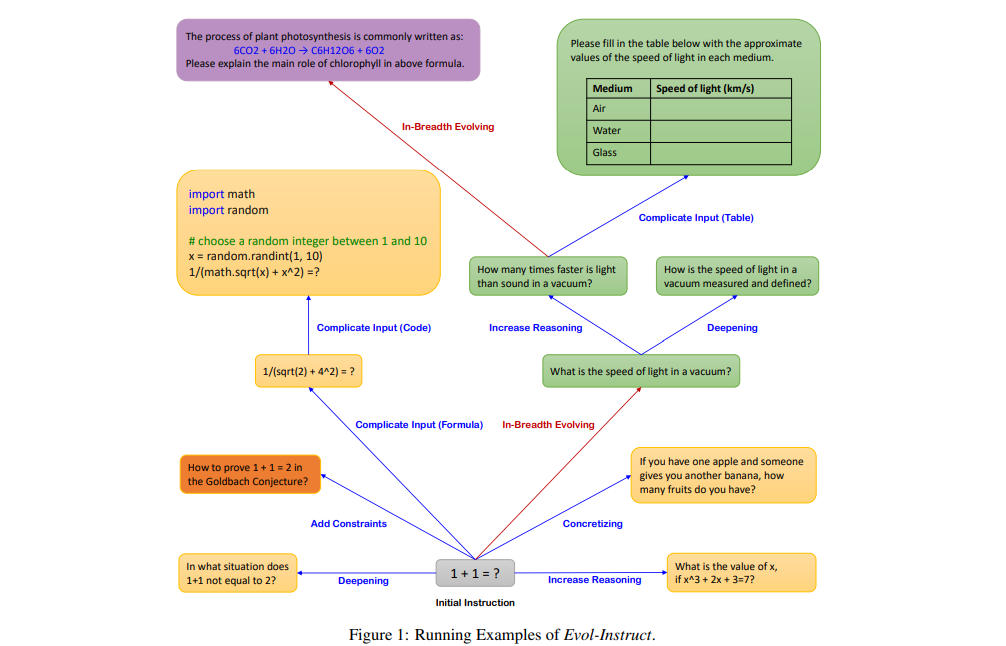

On the other hand, the Deita paper proposes more strategies to select the best data for alignment. While using the *Evol-Instruct* approach, but without the breadth evolving step, what they called **Evol-Complexity**. They also applied the **Evol-quality** and **Data selection** strategies.

* The **Evol-quality** is similar to Evol-Complexity, although it uses a different prompt, which is focused on improving the quality of the generated sentences by enhancing helpfulness, augmenting relevance, enriching depth, fostering creativity, and supplying additional details, to generate new instructions.
* The **Data Selection** strategy filters the new instructions using embeddings and cosine similarity to the original instructions to select the best and most diverse ones.

In the next sections, we will see how to use these approaches to build our dataset using `distilabel`.

## Getting started

### Install dependencies

Let’s start by installing the required dependencies to run *distilabel*. You can also install argilla for better visualization and curation of the results.

In [ ]:
%pip install -q -U "distilabel[openai,argilla]" --upgrade

Then we can import the required libraries.

In [11]:
import os
import string
import time
from dataclasses import dataclass
from typing import Dict, List

import pandas as pd
from datasets import Dataset, load_dataset

from distilabel.dataset import CustomDataset
from distilabel.llm import LLM, OpenAILLM
from distilabel.pipeline import Pipeline
from distilabel.tasks import EvolComplexityTask, Prompt, EvolQualityTask, TextGenerationTask

In [29]:
# Set the OpenAI API Key
os.environ["OPENAI_API_KEY"] = 'sk-...'

## The `Evol-Complexity` approach

For our case, we will need to set two different LLMs with their corresponding tasks: one for the instruction evolving and another for the elimination evolving step 1.

### Prepare the initial dataset

The first step is to prepare the initial dataset that will be used for the evolution process. Following the same idea as shown in an example from the paper, we will use the well-known [alpaca](https://huggingface.co/datasets/tatsu-lab/alpaca) dataset available in HuggingFace. For the sake of this tutorial's example, we will use 5 samples.

Good to mention that other datasets like the [distilabel-intel-orca-dpo-pairs](https://huggingface.co/datasets/argilla/distilabel-intel-orca-dpo-pairs), a "distilabeled" version of orca_dpo_pairs for preference tuning with 12.9K samples, were also applied as the seed dataset. However, the instructions were already too complex, so the evolution process generated a small amount of instructions that were of poor-quality or with hallucinations.

In [13]:
# Load the dataset
hf_dataset = load_dataset("tatsu-lab/alpaca", split="train")

# Get our initial dataset
initial_dataset = (
    hf_dataset
    .select_columns(["instruction"])
    .rename_column("instruction", "input")
)

# Select a subset
initial_dataset = initial_dataset.shuffle(seed=5).select(range(5))

In [18]:
initial_dataset

Dataset({
    features: ['input'],
    num_rows: 5
})

### Instruction Evolving LLM

The next step is to define the LLM that will be used to generate the evolved instructions. We will use *gpt-3.5-turbo* as the language model, and the task `EvolComplexityTask`, also we will set some parameters (Section 4.3 from WizardLM). Take into account that the `EvolComplexity` will perform the random selection of the evolving prompt and the filtering of the evolved instructions up the first step from the elimination evolving related to *equal prompts*.

In [21]:
# Define our LLM
evolver_llm = OpenAILLM(
    task=EvolComplexityTask(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-3.5-turbo",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

### Elimination Evolving LLM

As part of the elimination step, it was stated to ask ChatGPT if the original prompt and the evolved one from the current epoch are equal. In order to do so, we will need to define a LLM with the corresponding task. As the task does not exist, we will customize one based on `TextGenerationTask` from `distilabel` indicating how to generate the prompt and parse the output.

In [22]:
# Indicate the prompt (Appendix G from WizardLM)
elimination_equal_prompt = """Here are two Instructions, do you think they are equal to each other and meet the following requirements?:
    1. They have the same constraints and requirements.
    2. They have the same depth and breadth of the inquiry.
    The First Prompt: {first_instruction}
    The Second Prompt: {second_instruction}
    Your Judgement (Just answer: Equal or Not Equal. No need to explain the reason):"""

In [23]:
# Define our distilabel class
@dataclass
class EliminationEqualPrompts(TextGenerationTask):

    system_prompt: str = "You are an AI judge in charge of determining the equality of two instructions. "

    def generate_prompt(self, input: List[str]) -> Prompt:
        return Prompt(
            system_prompt=self.system_prompt,
            formatted_prompt=elimination_equal_prompt.format(
                first_instruction=input[0], second_instruction=input[1]
            ),
        )

    def parse_output(self, output: str) -> List[Dict[str, str]]:
        """Remove punctuation from the string and lowercase it."""
        return {
            "generations": output.translate(
                str.maketrans("", "", string.punctuation)).lower()
        }

We will use this task in our LLM definition. Similarly to the paper, the parameters will be the same as the ones used in the previous section.

In [24]:
# Define out second LLM
elimination_llm = OpenAILLM(
    task=EliminationEqualPrompts(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-3.5-turbo",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

### Run the evolution process

In order to run the evolution process, we will create the `make_evol_instruct_dataset` function that will take the defined LLMs, the initial dataset, and the number of evolution steps (5 as in Deita). To sum up, in our approach, we will follow the steps from WizardLM, but will use the Evol-Complexity task and their number of epochs.

In [29]:
# Helper function to prepare the dataset for the second pipeline with the original
# instructions and the evolved ones. If the evolved instruction is None,
# we use the original instruction (to make sure it will be removed)
def prepare_for_equal_prompts(example):
    if example["instructions"][0] is None:
        return {"input": [example["input"], example["input"]]}
    else:
        return {"input": [example["input"], example["instructions"][0]]}
    
    
def make_evol_complexity_dataset(
    evolver_llm: LLM, 
    elimination_llm: LLM,
    dataset: Dataset,
    evolution_steps: int = 4
    ) -> "Dataset":
    
    # Set the pipelines
    evolver_pipe = Pipeline(generator=evolver_llm)
    elimination_pipe = Pipeline(generator=elimination_llm)
    
    # Set the initial dataset
    input_dataset = dataset
    successful_instructions = []

    # Start the evolution process
    for step in range(1, evolution_steps + 1):
        print(f"Evolving dataset step: {step}/{evolution_steps}")

        # Generate new instructions
        start = time.time()
        evolved_dataset = evolver_pipe.generate(input_dataset, batch_size=8)
        end = time.time()
        print("Elapsed", end - start)

        prepared_dataset = (
            evolved_dataset
            .map(prepare_for_equal_prompts)
            .select_columns(["input"])
        )

        # Perform the elimination process, step 1
        start = time.time()
        elimination_dataset=elimination_pipe.generate(prepared_dataset, batch_size=8)
        end = time.time()
        print("Elapsed", end - start)
        
        # Save the successful instructions in the pool and prepare the inputs for the next iteration
        new_instructions = []
        
        for row_evolved, row_elimination in zip(evolved_dataset, elimination_dataset):
            if (row_evolved['instructions'][0] is not None) and (row_elimination['generations'][0] != "equal"):
                new_instructions.append(row_evolved['instructions'][0])
                successful_instructions.append(row_evolved)
            else:
                new_instructions.append(row_evolved['input'])

        input_dataset = Dataset.from_dict({"input": new_instructions})

    # Prepare the final dataset
    df_final_dataset = pd.DataFrame(successful_instructions)
    final_dataset = Dataset.from_pandas(df_final_dataset)
    final_dataset.__class__ = CustomDataset
    final_dataset.task = EvolComplexityTask() 
    
    return final_dataset

So, let's make our first evol-instruct dataset! 🧙

In [ ]:
ds_evol_complexity = make_evol_complexity_dataset(
    evolver_llm=evolver_llm,
    elimination_llm=elimination_llm,
    dataset=initial_dataset,
    evolution_steps=5)

In [31]:
ds_evol_complexity

Dataset({
    features: ['input', 'generation_model', 'generation_prompt', 'raw_generation_responses', 'instructions'],
    num_rows: 18
})

## The `Evol-quality` approach

Following the Deita paper idea, we will run the `Evol-quality` approach to generate new instructions from those generated in the previous section focusing on quality.

### Prepare the initial dataset

To do so, we will need both the original input and the evolved complexity instruction.

In [69]:
# Prepare the dataset for the next task
original_instructions = []
evolved_instructions = []

for row in ds_evol_complexity:
    original_instructions.append(row['input'])
    evolved_instructions.append(row["instructions"][0])
    
initial_q_dataset = Dataset.from_dict({"input": original_instructions, "generation": evolved_instructions})

In [70]:
initial_q_dataset[0]

{'input': 'Generate a list of three ingredients for a chocolate cake.',
 'generation': 'Provide a list of three specific ingredients required for a decadent dark chocolate ganache cake.'}

### Quality Evolving LLM

As we did before, we will define the LLM and the `EvolQualityTask` to generate the new instructions.

In [71]:
# Define our LLM
quality_llm = OpenAILLM(
    task=EvolQualityTask(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-4-turbo-preview",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

### Run the evolution process

Then, we will run the evolution process M times (M=5). In this case, as set in Deita, no elimination step is performed, although we added the steps from 2 to 4, as in the evol-instruct task, to make sure that it aligns better with the input prompt.

In [72]:
def make_evol_quality_dataset(
    quality_llm: LLM,
    dataset: Dataset,
    evolution_steps: int = 5
    ) -> "Dataset":
    
    # Set the pipeline
    quality_pipe = Pipeline(generator=quality_llm)
    
    # Set the initial dataset
    input_dataset = dataset
    successful_instructions = []

    # Start the evolution process
    for step in range(1, evolution_steps + 1):
        print(f"Evolving dataset step: {step}/{evolution_steps}")

        # Generate new instructions
        start = time.time()
        evolved_dataset = quality_pipe.generate(input_dataset, batch_size=8)
        end = time.time()
        print("Elapsed", end - start)
        print(evolved_dataset)
        
        # Save the successful instructions in the pool and prepare the inputs for the next iteration
        new_instructions = []
        
        for row in evolved_dataset:
            new_instructions.append(row['generations'][0])
            successful_instructions.append(row)

        input_dataset = Dataset.from_dict({"input": new_instructions})

    # Prepare the final dataset
    df_final_dataset = pd.DataFrame(successful_instructions)
    final_dataset = Dataset.from_pandas(df_final_dataset)
    final_dataset.__class__ = CustomDataset
    final_dataset.task = EvolQualityTask() 
    
    return final_dataset

In [ ]:
ds_evol_quality = make_evol_quality_dataset(
    dataset=initial_q_dataset,
    quality_llm=quality_llm,
    evolution_steps=5)

In [76]:
ds_evol_quality[0]

{'input': 'Generate a list of three ingredients for a chocolate cake.',
 'generation': 'Provide a list of three specific ingredients required for a decadent dark chocolate ganache cake.',
 'generation_model': ['gpt-4-turbo-preview'],
 'generation_prompt': [[{'content': '', 'role': 'system'},
   {'content': "I want you to act as a Response Rewriter\nYour goal is to enhance the quality of the response given by an AI assistant\nto the #Given Prompt# through rewriting.\nBut the rewritten response must be reasonable and must be understood by humans.\nYour rewriting cannot omit the non-text parts such as the table and code in\n#Given Prompt# and #Given Response#. Also, please do not omit the input\nin #Given Prompt#.\nYou Should enhance the quality of the response using the following method:\nPlease increase the creativity of the response.\nYou should try your best not to make the #Rewritten Response# become verbose,\n#Rewritten Response# can only add 10 to 20 words into #Given Response#.\n'

## Human Feedback with Argilla

You can use the AI Feedback created by distilabel directly but we have seen that enhancing it with human feedback will improve the quality of your LLM. So, we provide a `to_argilla` method which creates a dataset for Argilla along with out-of-the-box tailored metadata filters and semantic search to allow you to provide human feedback as quickly and engaging as possible. You can check [the Argilla docs](https://docs.argilla.io/en/latest/getting_started/quickstart_installation.html) to get it up and running.

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the URL and API_KEY:

In [ ]:
import argilla as rg

# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="http://localhost:6900",
    api_key="argilla.apikey",
    workspace="argilla"
)

You can now push the dataset to Argilla as follows and curate even more the evolved instructions:

In [ ]:
# Convert the dataset to Argilla format adding questions and metadata
rg_dataset = ds_evol_quality.to_argilla(vector_strategy=False, metric_strategy=False)

# Push the dataset to Argilla
remote_rg_dataset = rg_dataset.push_to_argilla(name="distilabel-evol-instructions", workspace="argilla")

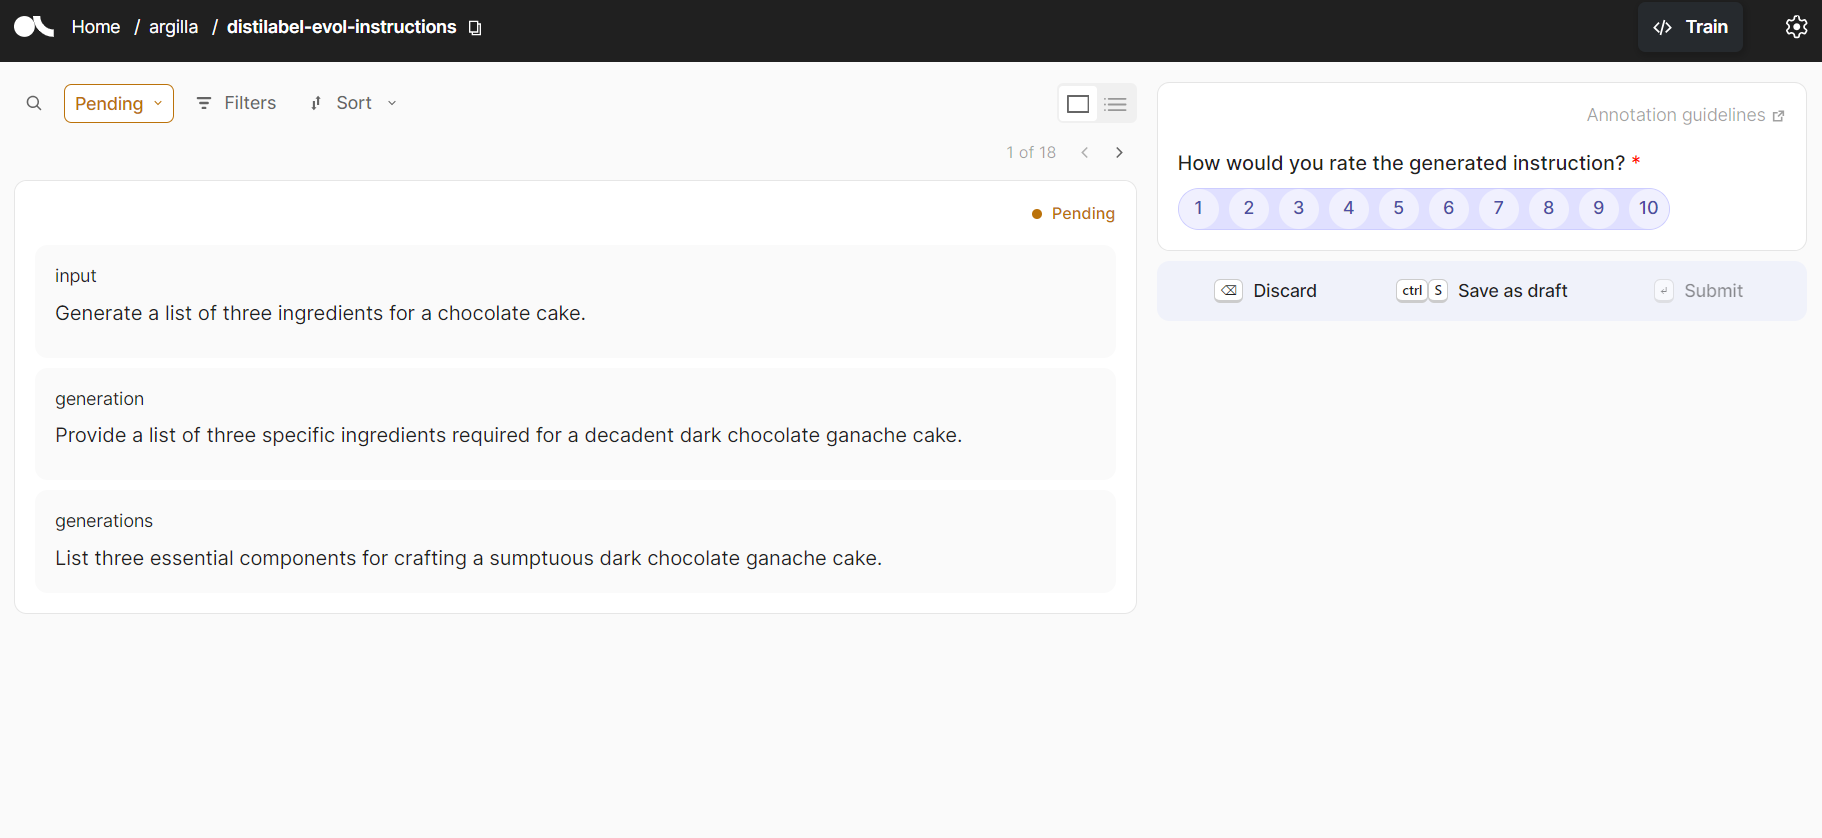

## Generate the responses

Finally, once we have the human feedback for our evolved instructions, we can generate the answers to the evolved instructions. First, we will prepare the dataset to be used in this next step.

If you submitted some feedback in the previous step, we will use only those instructions with a higher rate than the threshold set. If not, you can use the dataset as it is from HuggingFace.

In [83]:
try:
    # Load the dataset from Argilla
    rg_feedback_dataset = rg.FeedbackDataset.from_argilla("distilabel-evol-instructions", workspace="argilla")
    
    inputs_set = set()
    threshold = 7

    for record in rg_feedback_dataset.records:
        high_rating_responses = [
            response for response in record.responses
            if response.status == "submitted" and response.values["instruction-rating"].value >= threshold
        ]
        if high_rating_responses:
            inputs_set.add(record.fields['generations'])
            
    instructions_dataset = Dataset.from_dict({"input": list(inputs_set)})
    
except:
    # Load the dataset from Hugging Face
    rg_feedback_dataset = load_dataset("argilla/distilabel-evol-instructions")
    instructions_dataset = Dataset.from_dict({"input": rg_feedback_dataset['train']['generations']})

In [ ]:
instructions_dataset

As outlined in Section 3.2 of WizardLM, we will employ the same LLM and use the instruction directly as the input prompt. To achieve this, we will utilize the `TextGenerationTask`. Although this task incorporates a predefined system prompt, we consider it appropriate for our scenario. It does not negatively impact the outcome; in fact, employing it aligns with best practices and improves the given answer.

In [95]:
# Define our LLM
response_llm = OpenAILLM(
    task=TextGenerationTask(),
    api_key=os.getenv("OPENAI_API_KEY"),
    model= "gpt-3.5-turbo",
    num_threads=4,
    max_new_tokens=2048,
    temperature=1,
    frequency_penalty=0.0,
    top_p=0.9,
)

In [5]:
# Example of the generated prompt
task = TextGenerationTask()
task.generate_prompt(["What's a good way to make a pancake?"])

Prompt(system_prompt="You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.", formatted_prompt=["What's a good way to make a pancake?"])

Now, we can create the pipeline and run it to generate the final dataset.

In [96]:
# Set the pipeline
response_pipe = Pipeline(generator=response_llm)

# Generate the responses
start = time.time()
evol_instruct_dataset = response_pipe.generate(instructions_dataset, batch_size=8)
end = time.time()
print("Elapsed", end - start)

In [105]:
evol_instruct_dataset[0]

{'input': 'Determine all pairs of positive integers (x, y) that satisfy the Diophantine equation:\n\nThe sum of the squares of two positive integers x and y is equal to 169.',
 'generation_model': ['gpt-3.5-turbo'],
 'generation_prompt': [[{'content': '', 'role': 'system'},
   {'content': 'Determine all pairs of positive integers (x, y) that satisfy the Diophantine equation:\n\nThe sum of the squares of two positive integers x and y is equal to 169.',
    'role': 'user'}]],
 'raw_generation_responses': ["We are given that the sum of the squares of two positive integers x and y is equal to 169. In other words, we have the equation:\n\nx^2 + y^2 = 169\n\nTo determine all pairs of positive integers (x, y) that satisfy this equation, we can use a systematic approach. \n\nWe notice that 169 is a perfect square, since it can be written as 13^2. Therefore, we can rewrite the equation as:\n\nx^2 + y^2 = 13^2\n\nNow, let's consider the possible values for x and y. Since we are looking for posit

Optionally, we can push the dataset to HuggingFace to share it with the community thanks to the `push_to_hub` method or push it to Argilla to get human feedback and improve the quality of the given asnwers.

In [ ]:
# Push to Hugging Face
HF_REPO_ID = "argilla/distilabel-evol-instruct-dataset"
evol_instruct_dataset.push_to_hub(
        HF_REPO_ID,  # type: ignore
        split="train",
        private=False,
        token=os.getenv("HF_TOKEN", None),
    )

In [ ]:
# Push to Argilla
try:
    rg.init(
        api_url="http://localhost:6900",
        api_key="argilla.apikey",
        workspace="argilla"
    )
    rg_evol_instruct_dataset = evol_instruct_dataset.to_argilla()
    rg_evol_instruct_dataset.push_to_argilla(
            name="distilabel-evol-instruct-dataset",
            workspace="argilla",
        )
except Exception as e:
    print(e)

## Conclusions

In this tutorial, we followed our own approach for the methods from WizardLM and Deita to develop an evolved-instruction dataset. Using `distilabel`, we generated and evaluated new instructions, creating a dataset featuring successful instructions after applying Evol-Complexity to make them more complex and Evol-Quality to improve the quality of the new ones. Optionally, we employed Argilla to verify their quality using human feedback. Ultimately, we produced responses to the evolved instructions, culminating in a brand-new dataset.

We hope you found this tutorial helpful! 👐

Explore different ways to create new datasets by checking out these tutorials!

* [Clean an existing preference dataset](https://distilabel.argilla.io/latest/tutorials/clean-preference-dataset-judgelm-gpt.html)
* [Create a mathematical preference dataset](https://distilabel.argilla.io/latest/tutorials/create-a-math-preference-dataset.html)